In [11]:
# Block 1: Load the Dataset
import pandas as pd

# Load the dataset
file_path = '/content/hate_speech_binary.csv'
data = pd.read_csv(file_path)

# Display basic information
print("Dataset Info:")
data.info()

# Preview the first few rows
print("\nFirst 5 rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4579 entries, 0 to 4578
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  4579 non-null   object
 1   Hate     4579 non-null   object
dtypes: object(2)
memory usage: 71.7+ KB

First 5 rows:
                                             Comment Hate
0  Knowing ki Vikas kitna samjhata hai Priyanka a...   no
1  I am Muhajir .. Aur mere lye sab se Pehly Paki...   no
2  Doctor  sab sahi me ke PhD (in hate politics) ...   no
3  Poore Desh me Patel OBC me aate Hain sirf gujr...   no
4  Sarkar banne ke bad Hindu hit me ek bhi faisla...  yes

Missing values:
Comment    0
Hate       0
dtype: int64


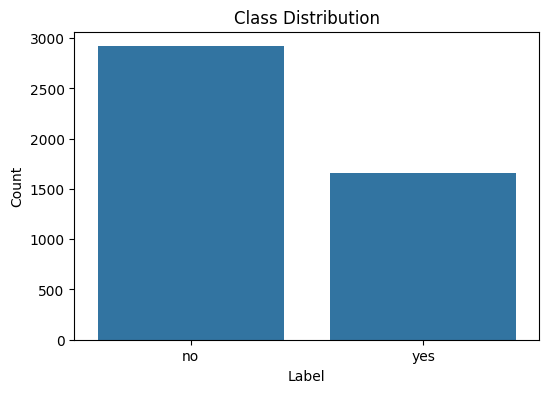

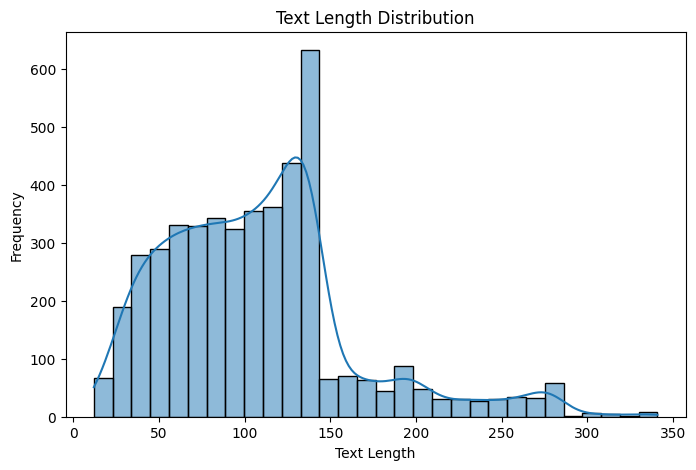

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Hate', data=data)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Analyze text length
data['text_length'] = data['Comment'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [13]:
# Map 'Hate' column to binary values
print("\nUnique values in 'Hate':", data['Hate'].unique())
data['Hate'] = data['Hate'].str.strip().str.lower()
data['Hate'] = data['Hate'].map({'yes': 1, 'no': 0})

# Basic text cleaning
data['Comment'] = data['Comment'].str.lower()
data['Comment'] = data['Comment'].str.replace(r'\W', ' ', regex=True)
data['Comment'] = data['Comment'].str.strip()

# Recalculate text length after cleaning
data['text_length'] = data['Comment'].apply(len)


Unique values in 'Hate': ['no' 'yes']


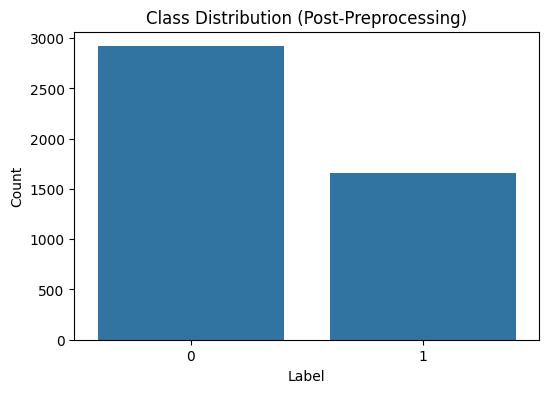

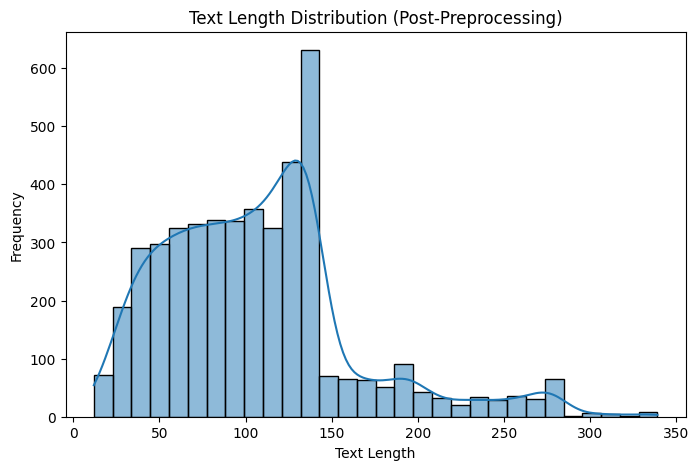

In [14]:
# Class distribution (post-preprocessing)
plt.figure(figsize=(6, 4))
sns.countplot(x='Hate', data=data)
plt.title("Class Distribution (Post-Preprocessing)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


# Text length distribution (post-preprocessing)
plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title("Text Length Distribution (Post-Preprocessing)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Comment'], data['Hate'], test_size=0.2, random_state=42
)

print("\nTraining set size:", len(train_texts))
print("Validation set size:", len(val_texts))


Training set size: 3663
Validation set size: 916


In [16]:
from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize a sample
sample_text = train_texts.iloc[0]
tokens = tokenizer.tokenize(sample_text)
print("\nSample tokenized text:", tokens)

# Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("\nToken IDs:", token_ids)


Sample tokenized text: ['jis', 'din', 'ye', 'kan', '##un', 'b', '##n', 'g', '##ya', 'ki', 'rape', 'kr', '##ne', 'wa', '##le', 'ko', 'b', '##hre', 'baja', '##r', 'm', 'nap', '##uns', '##ak', 'b', '##nay', '##a', 'ja', '##ye', '##ga', 'us', 'din', 'bet', '##iya', 'ji', 'pay', '##eng', '##i']

Token IDs: [28882, 10595, 11023, 10905, 11107, 170, 10115, 175, 10679, 10879, 82523, 50302, 10238, 11471, 10284, 11252, 170, 32206, 34222, 10129, 181, 64728, 62387, 10710, 170, 30771, 10113, 10201, 12871, 10483, 19626, 10595, 13009, 14990, 18028, 16868, 23923, 10116]


In [17]:
import numpy as np

# Define a function to tokenize and encode text
def encode_texts(texts, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'][0].numpy())
        attention_masks.append(encoded['attention_mask'][0].numpy())

    # Ensure labels are in numpy format
    labels = np.array(labels)

    return np.array(input_ids), np.array(attention_masks), labels

# Convert train_labels and val_labels to lists if necessary
train_labels = train_labels.tolist() if not isinstance(train_labels, list) else train_labels
val_labels = val_labels.tolist() if not isinstance(val_labels, list) else val_labels

# Encode train and validation sets
train_input_ids, train_attention_masks, train_labels = encode_texts(train_texts, train_labels, tokenizer)
val_input_ids, val_attention_masks, val_labels = encode_texts(val_texts, val_labels, tokenizer)


In [18]:
from transformers import TFBertModel
import tensorflow as tf

# Define the model
def create_model():
    bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

    input_ids = tf.keras.Input(shape=(128,), dtype='int32', name='input_ids')
    attention_mask = tf.keras.Input(shape=(128,), dtype='int32', name='attention_mask')

    bert_output = bert_model(input_ids, attention_mask=attention_mask)
    pooled_output = bert_output.pooler_output  # Use pooled output
    dense = tf.keras.layers.Dense(1, activation='sigmoid')(pooled_output)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=dense)
    return model

# Instantiate the model
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1778534   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                     

In [19]:
# Train the model
history = model.fit(
    [train_input_ids, train_attention_masks],
    train_labels,
    validation_data=([val_input_ids, val_attention_masks], val_labels),
    batch_size=16,
    epochs=30
)


Epoch 1/30
229/229 [==============================] - 140s 447ms/step - loss: 0.6667 - accuracy: 0.6235 - val_loss: 0.6335 - val_accuracy: 0.6670
Epoch 2/30
229/229 [==============================] - 104s 452ms/step - loss: 0.6616 - accuracy: 0.6284 - val_loss: 0.6411 - val_accuracy: 0.6670
Epoch 3/30
229/229 [==============================] - 105s 457ms/step - loss: 0.6580 - accuracy: 0.6211 - val_loss: 0.6224 - val_accuracy: 0.6681
Epoch 4/30
229/229 [==============================] - 105s 459ms/step - loss: 0.6116 - accuracy: 0.6683 - val_loss: 0.5513 - val_accuracy: 0.7424
Epoch 5/30
229/229 [==============================] - 105s 460ms/step - loss: 0.5697 - accuracy: 0.7013 - val_loss: 0.5505 - val_accuracy: 0.7282
Epoch 6/30
229/229 [==============================] - 105s 459ms/step - loss: 0.5389 - accuracy: 0.7210 - val_loss: 0.5689 - val_accuracy: 0.7380
Epoch 7/30
229/229 [==============================] - 105s 459ms/step - loss: 0.4762 - accuracy: 0.7666 - val_loss: 0.5691 -

29/29 [==============================] - 11s 272ms/step

Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.75      0.88      0.81       611
        Hate       0.63      0.40      0.49       305

    accuracy                           0.72       916
   macro avg       0.69      0.64      0.65       916
weighted avg       0.71      0.72      0.70       916



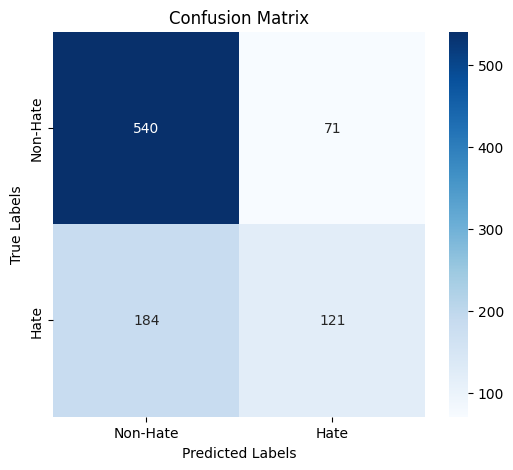

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the validation set
val_predictions = model.predict([val_input_ids, val_attention_masks])
val_predictions = (val_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate using sklearn metrics
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions, target_names=['Non-Hate', 'Hate']))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [21]:
# Save the model
model.save('/content/hinglish_hate_speech_model')
print("Model saved successfully!")

Model saved successfully!
